In [1]:
import numpy as np
import qutip as qt
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
from qbism import sic_povm

In [2]:
@jit
def vec(A):
    return A.flatten()


@jit
def generate_map(G):
    g_of_t = G
    return jnp.array(
        [
            [jnp.conjugate(g_of_t) * g_of_t, 0, 0, 0],
            [0, g_of_t, 0, 0],
            [0, 0, jnp.conjugate(g_of_t), 0],
            [1 - jnp.conjugate(g_of_t) * g_of_t, 0, 0, 1],
        ]
    )


@jit
def G(t, lamda, gamma_0):
    delta = jnp.sqrt((1 - 2 * gamma_0 / lamda) + 1j * 0)
    return jnp.exp(-lamda * t / 2) * (
        jnp.cosh(lamda * t / 2 * delta)
        + 1 / delta * jnp.sinh(lamda * t / 2 * delta)
    )


@jit
def name_of_fun(
    initial_state,
    sic_povm_array,
    times_array,
    lamda,
    gamma_0,
):
    evolved_rho = jax.vmap(
        lambda t: generate_map(G(t, lamda, gamma_0)) @ vec(initial_state)
    )(times_array)

    evolved_probabilities = jax.vmap(
        lambda rho: jnp.einsum("kj, ijk", rho.reshape(2, 2), sic_povm_array)
    )(evolved_rho)

    return evolved_probabilities

In [31]:
def dag(A):
    return np.conjugate(A.T)


def sprepost(A, B):
    return np.kron(A, np.transpose(B))


def spre(A):
    return sprepost(A, np.identity(2))


def spost(A):
    return sprepost(np.identity(2), A)

In [32]:
spsm = qt.sigmap() * qt.sigmam()
sp = np.array(qt.sigmap().full())
sm = np.array(qt.sigmam().full())

spsm = np.array(spsm.full())

In [33]:
omega0 = 1

Hs = omega0 * spsm
print(Hs)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [34]:
unitary_super = -1j / 2 * (spre(spsm) - spost(spsm))

dissipative_super = sprepost(sm, dag(sm)) - 0.5 * (
    spre(sp @ sm) + spost(sp @ sm)
)


make_L = lambda S, gamma: S * unitary_super + gamma * dissipative_super

In [35]:
dissipative_super

array([[-1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j, -0.5+0.j,  0. +0.j],
       [ 1. +0.j,  0. +0.j,  0. +0.j,  0. +0.j]])

In [36]:
@jit
def gamma_t(t, lamda, gamma_0):
    delta = jnp.sqrt((1 - 2 * gamma_0 / lamda) + 1j * 0)

    return (
        2
        * gamma_0
        * (
            (jnp.sinh(delta * lamda * t / 2))
            / (
                delta * jnp.cosh(delta * t / 2 * lamda)
                + jnp.sinh(lamda * t * delta / 2)
            )
        )
    )

In [37]:
lamda = 0.8
gamma_0 = 0.8 * lamda / 2  # weak coupling
# gamma_0 = 20 * lamda / 2  # strong coupling


times = np.linspace(0, 25, 5000)

initial_rho0 = np.array(qt.rand_dm(2, seed=8).full())

sic_array = np.array(sic_povm(2))

/opt/homebrew/Caskroom/mambaforge/base/envs/data-sci/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/mambaforge/base/envs/data-sci/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


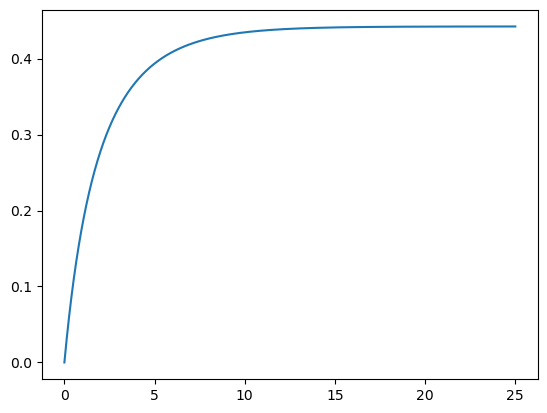

In [39]:
plt.plot(times, np_gamma_t(times, lamda, gamma_0))

In order to integrate the function we may implement this in numpy through scipy

In [40]:
def np_gamma_t(t, lamda, gamma_0):
    delta = np.sqrt((1 - 2 * gamma_0 / lamda) + 1j * 0)

    return (
        2
        * gamma_0
        * (
            (np.sinh(delta * lamda * t / 2))
            / (
                delta * np.cosh(delta * t / 2 * lamda)
                + np.sinh(lamda * t * delta / 2)
            )
        )
    )

In [41]:
def function_to_integrate(t, rho_vec, lamda, gamma_0):
    gamma_decay = np_gamma_t(t, lamda, gamma_0)
    S = 0
    L = make_L(S, gamma_decay)
    return L @ rho_vec

In [68]:
from scipy import integrate

f_to_quad = lambda t, rho: function_to_integrate(t, rho, lamda, gamma_0)
sol = integrate.solve_ivp(
    f_to_quad, t_span=(0, 25.0), y0=vec(initial_rho0_df), t_eval=times
)

/opt/homebrew/Caskroom/mambaforge/base/envs/data-sci/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/Caskroom/mambaforge/base/envs/data-sci/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


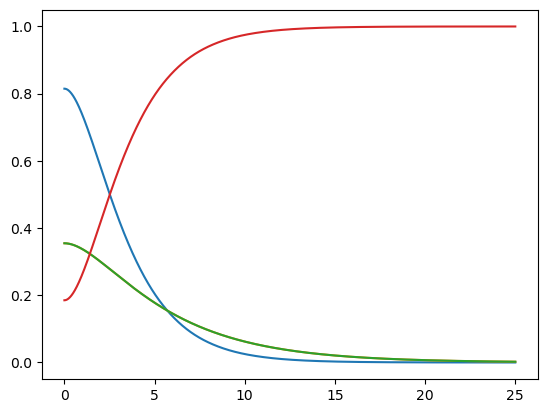

In [69]:
plt.plot(times, sol.y.T)

In [67]:
import joblib

initial_rho0_df = joblib.load("weak_coupling_dataset.job")["Initial_rhos"][45]

In [60]:
sol.y.T[0]

array([0.62059778+0.j        , 0.27054381-0.13533728j,
       0.27054381+0.13533728j, 0.37940222+0.j        ])

In [70]:
evolved_probabilities = jax.vmap(
    lambda rho: jnp.einsum("kj, ijk", rho.reshape(2, 2), sic_array)
)(sol.y.T)

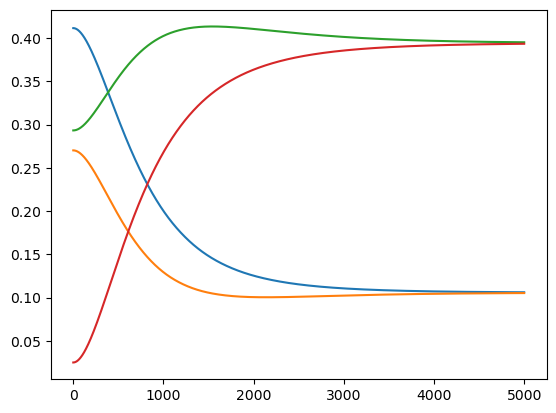

In [71]:
plt.plot(evolved_probabilities)